# Data Analysis on "Warlog" data.
The introduction to the problem and the objective can be read in the README.md file. To sum it up, the objective is finding the relation that exists between the features available and the event type. The problem is of the type "classification with multiple categories", with a focus on the interpretability of the models, as we want to identify the characteristics of the event types.

After a brief phase of data exploration and feature cleaning, some models will be used to understand the relation.

## Data exploration

In [69]:
#The libraries required.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [70]:
#Loading the data.
warlog = pd.read_csv("DATA/warlogs.csv")

There are more than 50k war logs.

In [71]:
warlog.head(1)

,report_key,to_timestamp,Type,category,region,attack_on,coalition_forces_wounded,coalition_forces_killed,iraq_forces_wounded,iraq_forces_killed,civilian_wia,civilian_kia,enemy_wia,enemy_kia,enemy_detained,total_deaths,st_x,st_y
0,9488,2004-01-01 03:00:00+01,Non-Combat Event,Accident,MND-BAGHDAD,NEUTRAL,0,2,0,0,0,0,0,0,0,2,44.390114,33.299713


First, let's remove the variables that won't be used. The first one is "report_key", the identifier, and "category", a finer classification of events.

In [72]:
warlog = warlog.drop("report_key", axis = 1)
warlog = warlog.drop("category", axis = 1) #This is the specific category of the report. I won't be used as it's a finer classification of "Type".

Then, the variable "Type" should be cleaned up, as there are some typos.

In [73]:
warlog.loc[warlog["Type"] == "EXPLOSIVE HAZARD","Type"] = "Explosive Hazard"
warlog.loc[(warlog["Type"] == "criminal event") | (warlog["Type"] == "CRIMINAL EVENT"),"Type"] = "Criminal Event"

The first objective is to undestand the characteristics of each type of report. This is more of an exploratory analysis, so the models used will be relatively simple.

### Some plots
There is the need for some plots, as the objective is understanding what happens in the event logs.

1] Plot of the variable of interest, the type of log. 

In [74]:
categories = warlog["Type"].value_counts().index.to_numpy()

In [75]:
count = warlog["Type"].value_counts().to_numpy()

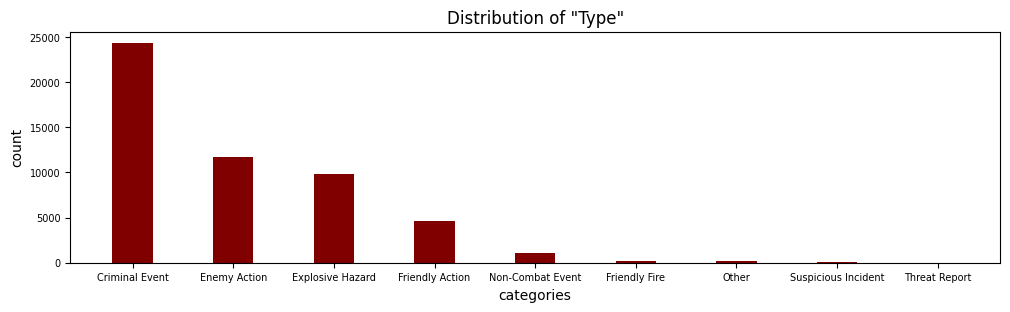

In [76]:
fig = plt.figure(figsize = (12, 3))

plt.bar(categories, count, color = "maroon", width = 0.4)
plt.xlabel("categories")
plt.ylabel("count")
plt.title('Distribution of "Type"')

#Size of the values in the axis
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

Clearly, there is a big unbalance in the distribution of the data. This needs to be fixed when training models, either through oversampling (or SMOTE), or by using higher weights for the minority classes.

2] Barplot of the mean of variables for each level of "Type". This works better than boxplots in this context.

In [77]:
tdeathsByType = warlog.loc[:,["Type","total_deaths"]].groupby("Type").mean()["total_deaths"].sort_values(ascending = False).to_numpy()
categories = warlog.loc[:,["Type","total_deaths"]].groupby("Type").mean()["total_deaths"].sort_values(ascending = False).index.to_numpy()

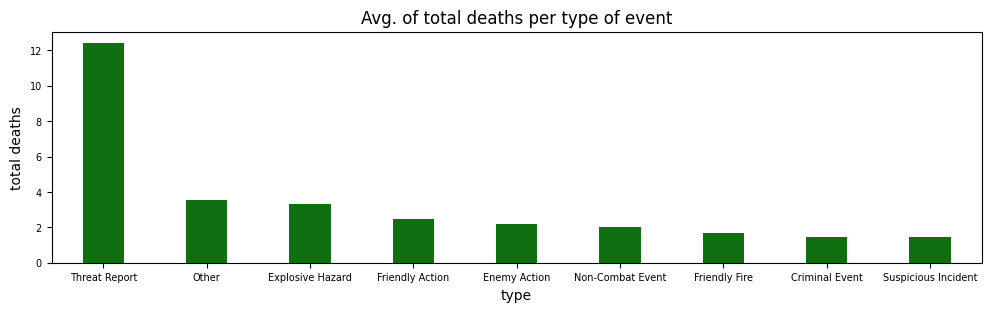

In [78]:
fig = plt.figure(figsize = (12, 3))

sns.barplot(x = categories, y = tdeathsByType, color = "green", width = 0.4)
plt.xlabel("type")
plt.ylabel("total deaths")
plt.title("Avg. of total deaths per type of event")

#Size of the values in the axis
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

The deadliest events are those categorized as "Threat Reports", "Other" (which is unclear what represents) and Explosive Hazard. It could be interesting to split the death count between each type: coalition forces, iraqi forces, enemies and civilians. This will be done in the following plot.

In [79]:
#First thing first, the datasets needed to make the plot.
coa_forces = warlog[["Type","coalition_forces_killed"]].groupby("Type").mean()
iraqi_forces = warlog[["Type","iraq_forces_killed"]].groupby("Type").mean()
civilians = warlog[["Type","civilian_kia"]].groupby("Type").mean()
enemies = warlog[["Type","enemy_kia"]].groupby("Type").mean()

#The final dataset used to make the plot.
killPlot = pd.concat([coa_forces,iraqi_forces,civilians,enemies], axis = 1)
killPlot["Type"] = killPlot.index

#The dataset in long format, needed for plot.
killPlot_long = pd.melt(killPlot, id_vars=["Type"], 
                  value_vars=["coalition_forces_killed","iraq_forces_killed","civilian_kia","enemy_kia"],
                  var_name='Variable', value_name='killCount')

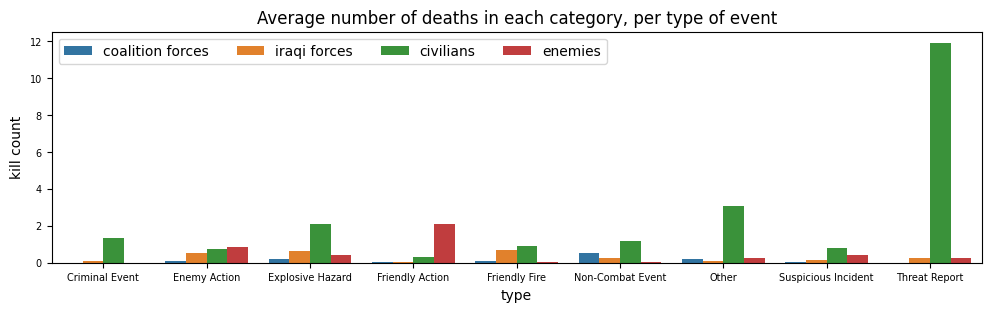

In [80]:
#This creates a barplot, showing the average killcount, per event and by type of individual.
plt.figure(figsize = (12, 3))
sns.barplot(x='Type', y='killCount', hue='Variable', data=killPlot_long)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

handles, _ = plt.gca().get_legend_handles_labels() #Retrieve the colors
plt.legend(handles = handles, ncol=4, labels = ["coalition forces","iraqi forces","civilians","enemies"],)

plt.ylabel("kill count")
plt.xlabel("type")
plt.title("Average number of deaths in each category, per type of event")
plt.show()

Clearly the kill count is greatly related to the type of event. Most deaths tend to involve civilians, but there are some types associated with the deaths of other individuals:
* In friendly actions, most deaths involve enemy personel.
* In enemy actions too, but there is a higher count of civilians and iraqi forces killed. This type of event has a more balanced distribution of deaths.
* The type of report called "Non-Combat Event" shows the higher number of coalition forces killed.
* Clearly, in threat reports, the number of civilians killed is great.

From this plot, we can see how each type of event is characterized thorugh different patterns of loss of life. If a report contains a high number of civilians killed, then it's most likely of the "threat report", "other" or "Explosive Hazard" type, with the first one being much more likely.\
If it involves the death of coalition forces, then it's most likely a "Non-Combat Event".\
When iraqi forces die, then the event is easily of the type "Friendly fire" or "Enemy Action".

3] It could be of interest to determine wheter some regions are characterized by a greater number of deaths per event, representing more conflict in the area. To do so, will be used a heatmap-like plot.

In [87]:
#Creating the data in the right format for the heatmap.
#First, the coordinates need to be organized in regions. This will be euristically.
x_bins = np.linspace(warlog["st_x"].min(), warlog["st_x"].max(), 20) 
y_bins = np.linspace(warlog["st_y"].min(), warlog["st_y"].max(), 20) 

In [88]:
#To get the values, instead of the count.
heatmap_data, x_edges, y_edges = np.histogram2d(
    warlog["st_x"], warlog["st_y"], bins=[x_bins, y_bins], weights=warlog['total_deaths'], density=False)

x_edges = [round(x,2) for x in x_edges]
y_edges = [round(x,2) for x in y_edges]

#To get the count.
counts, _, _ = np.histogram2d(warlog["st_x"], warlog["st_y"], bins=[x_bins, y_bins])

In [89]:
#Heatmap data, where the total number of deaths per area is divided by the number of events
heatmap_data = np.divide(heatmap_data, counts, where=counts!=0)

#The final data to be used is a grid of the mean number of kills per event in an area.

In [90]:
#Now the heatmap
heatmap_df = pd.DataFrame(heatmap_data, 
                          index= x_edges[0:(len(x_edges) - 1)], 
                          columns= y_edges[0:(len(y_edges) - 1)])

In [91]:
heatmap_df = heatmap_df.iloc[::-1]

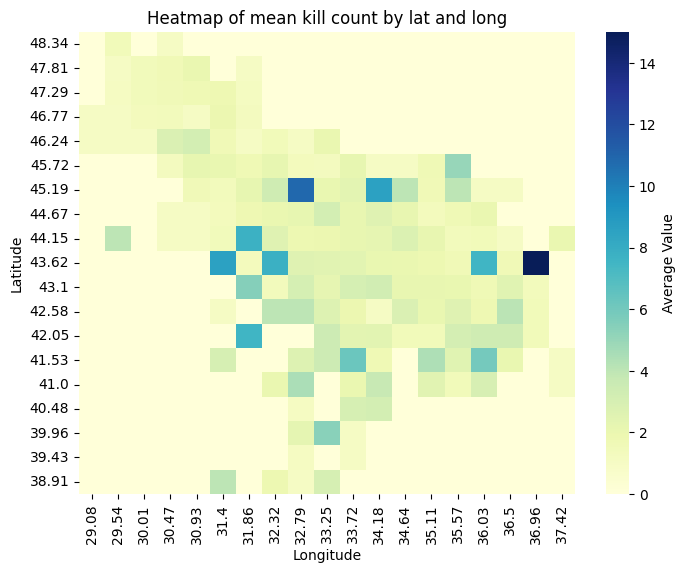

In [92]:
# Plot the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, cmap='YlGnBu', cbar_kws={'label': 'Average Value'})

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of mean kill count by lat and long')

# Display the plot
plt.show()

Clearly, some areas of Iraq see more conflict and victims than others. Given what we saw in the plots representing the death count per event type, it's clear the location of the event could be related to it's type.

# Models
In the following section, some models will be used to determine the characteristics of each type of event.

The problem is of the type multiple category classification, and it's of importance the interpretability aspect of the models. So, models that can be interpreted will be used first.

It's really import to determine which variables should be included, and how. The geographical location can be included with either region, the coordinates, or both. As region only has 7 values, it's kept alongside the geographical coordinates.\
Attack_on could be somewhat weird, as the target of the attack should be partially determined by the type of report, and could be a proxy variable. For example, "Enemy attack" has "enemy target". In the table below, it can be seen as the two variables are connected in a deterministic way, so it's removed from the analysis.


In [19]:
pd.crosstab(warlog["Type"],warlog["attack_on"])

attack_on,ENEMY,FRIEND,NEUTRAL
Type,,,
Criminal Event,24360,0,0
Enemy Action,11681,0,0
Explosive Hazard,9879,0,0
Friendly Action,0,4636,0
Friendly Fire,0,184,0
Non-Combat Event,0,0,1107
Other,0,0,146
Suspicious Incident,32,0,0
Threat Report,23,0,0


In [20]:
warlog = warlog.drop("attack_on", axis = 1)

Another feature that needs work is "to_timestamp", which can't be directly used. Something useful could be extracted, such as the year and the month. The report, in fact, is not made at the same time as the incident, and the timestamp is only the release date. So, the general time point is the only useful information that can be gained, not the hour or the day.

In [21]:
#Making a datetime series
warlog["to_timestamp"] = pd.to_datetime(warlog["to_timestamp"], utc = True)

#Year and month are obtained.
warlog["year"] = warlog["to_timestamp"].dt.year
warlog["month"] = warlog["to_timestamp"].dt.month

#The timestamp is then removed.
warlog = warlog.drop("to_timestamp", axis = 1)

The variable "region" has some missing values (49). This is a small proportion of data (50k+ rows), so the missing data is removed.

In [22]:
warlog = warlog.dropna()
warlog = warlog.reset_index(drop=True)

The "total deaths" variable is the sum of the other "deaths" variables, so it can be removed, as it contains redundant information. 

In [23]:
warlog = warlog.drop("total_deaths", axis=1)

Then, the categorical variables, such as "region", is converted to dummy.

In [24]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(warlog[["region"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["region"]))

In [25]:
data = pd.concat([warlog.drop("region", axis=1), encoded_df], axis=1)

### Model evaluation
The procedure followed will be a traditional one: different models will be estimated, and the best ones used to identify the importance of features and their relation with the type of event. For the performance comparison, a test set will be created and set apart. The metrics used will be the correct classification rate and the Macro averaged F1 score, one of the best metrics to use in multiclass problems: this is the mean of the F1 score calculated for each class, in a "one vs rest" fashion. This could help select the model with best classification across all classes, giving each one the same weight, considering they should have the same weight.

For the regulation of the models that need it, 5 folds cross-validation will be used.

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 100)

In [28]:
categories = warlog["Type"].unique()

In [29]:
def precision(pred, y, label):
    dfCond = pd.DataFrame({"pred":pred, "y":y}) #It's easier to write it like so.
    dfCond = dfCond.loc[dfCond["pred"] == label] #This dataframe contains all cases in the "label" class.

    if dfCond.shape[0] == 0: return 0

    #Else
    return sum(dfCond["y"] == label) / dfCond.shape[0]

def recall(pred, y, label):
    dfCond = pd.DataFrame({"pred":pred, "y":y})
    dfCond = dfCond.loc[dfCond["y"] == label]

    if dfCond.shape[0] == 0: return 0

    #Else
    return sum(dfCond["pred"] == label) / dfCond.shape[0]

def F1score(pred, y, label):
    if (precision(pred, y, label) == 0 or recall(pred, y, label) == 0): return 0
    return ( 2 * precision(pred, y, label) * recall(pred, y, label) ) / ( precision(pred, y, label) + recall(pred, y, label) )

def F1scoreMA (pred, y):
    F1s = [F1score(pred, y, item) for item in categories]
    return sum(F1s) / len(F1s)

### Multinomial Logit Model
This is a parametric model, an extention of the logit model (for binary classification) to a case with multiple categories. Similarly to a logit model, a logit function is used to model a relation between the probability of a category and the features used. This is one of the most interpretable models for multiple category classification, if not the most.

The estimation will happen in the training set, the evaluation in the test set.

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
MMmodel = LogisticRegression(penalty = None, multi_class = "multinomial", solver = "newton-cg", max_iter=1000)

In [ ]:
MMmodel.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"]);

Then we evaluate the classification performance, using the misclassification error. Here, in fact, the classes are equivalent, so are the types of error.

In [33]:
results = pd.DataFrame({"model":"multilogit",
                        "correct class. %":[MMmodel.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"])],
                       "F1scoreMA": [F1scoreMA(pred = MMmodel.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])]})
results

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946


Now, the problem with this model is that it predicts somewhat well "Criminal Events" and "Enemy Action", categories with numerous cases, but doesn't do a good job with the others. The following table shows the confusion matrix with the absolute frequency of pairs (predicted vs observed class). 

In [34]:
df = pd.DataFrame({"y":test_set["Type"],
                   "pred":pd.Series(MMmodel.predict(test_set.drop("Type", axis = 1)), index = test_set.index )})
pd.crosstab(df["y"],df["pred"])

pred,Criminal Event,Enemy Action,Explosive Hazard,Friendly Action,Non-Combat Event,Other
y,,,,,,
Criminal Event,4626,142,19,6,0,0
Enemy Action,986,907,311,169,8,0
Explosive Hazard,338,614,906,84,6,2
Friendly Action,165,445,32,334,0,0
Friendly Fire,16,4,8,1,0,0
Non-Combat Event,62,47,102,3,10,0
Other,9,7,17,3,1,0
Suspicious Incident,3,2,0,0,0,0
Threat Report,5,0,0,0,0,0


Let's break down the classification error for each class.

In [35]:
classes = data["Type"].unique()
correctClass = dict()

#A loop to get the misclassification error for each class
for label in classes:
    dfCond = df.loc[df["y"] == label]
    correctClass[label] = [sum(dfCond["y"] == dfCond["pred"]) / sum(df["y"] == label)]

correctClass = pd.DataFrame(correctClass)
correctClass

,Non-Combat Event,Criminal Event,Friendly Action,Explosive Hazard,Enemy Action,Other,Suspicious Incident,Threat Report,Friendly Fire
0,0.044643,0.965158,0.342213,0.464615,0.380932,0.0,0.0,0.0,0.0


Clearly, the only class where the classification is good is for the criminal events, for the others it is not.

### Multinomial Logit Model with weights
A solution would be to increase the weights of the observations in the less represented class. An euristich approach is to assign a weight inversely proportional to the relative frequency of the category.

In [ ]:
#Creating weights.
MMmodelW1 = LogisticRegression(penalty = None, multi_class = "multinomial",
                             solver = "newton-cg", max_iter=1000,
                            class_weight = "balanced") #The balanced mode assigns weights to classes exactly as mentioned.
MMmodelW1.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"]);

In [37]:
df = pd.DataFrame({"y":test_set["Type"],
                   "pred":pd.Series(MMmodelW1.predict(test_set.drop("Type", axis = 1)), index = test_set.index )})
pd.crosstab(df["y"],df["pred"])

pred,Criminal Event,Enemy Action,Explosive Hazard,Friendly Action,Friendly Fire,Non-Combat Event,Other,Suspicious Incident,Threat Report
y,,,,,,,,,
Criminal Event,2983,16,10,3,173,60,289,763,496
Enemy Action,264,111,83,348,349,115,187,553,371
Explosive Hazard,100,78,385,172,283,245,235,315,137
Friendly Action,52,14,11,491,19,10,18,229,132
Friendly Fire,2,2,3,0,4,1,2,9,6
Non-Combat Event,14,3,8,4,36,74,30,40,15
Other,3,0,0,3,1,3,19,3,5
Suspicious Incident,0,0,0,0,1,0,1,2,1
Threat Report,2,0,0,0,0,0,0,1,2


In [38]:
results.loc[len(results.index)] = ["Multilogit weighted",
                                   MMmodelW1.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"]),
                                  F1scoreMA(pred = MMmodelW1.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])]
results

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946
1,Multilogit weighted,0.391442,0.208971


In [39]:
classes = data["Type"].unique()
correctClass = dict()

#A loop to get the misclassification error for each class
for label in classes:
    dfCond = df.loc[df["y"] == label]
    correctClass[label] = [sum(dfCond["y"] == dfCond["pred"]) / sum(df["y"] == label)]

correctClass = pd.DataFrame(correctClass)
correctClass

,Non-Combat Event,Criminal Event,Friendly Action,Explosive Hazard,Enemy Action,Other,Suspicious Incident,Threat Report,Friendly Fire
0,0.330357,0.622366,0.503074,0.197436,0.046619,0.513514,0.4,0.4,0.137931


The performance of the model drops, for both metrics. From the confusion matrix above it can be seen as the predictions are better on the less represented categories, but worsen considerably on the more represented ones. This implies that this model has an hard time separating the classes through the features, so every attempt at increasing the weight of the minority classes leads to "stealing" correct classifications from the more represented ones. This leads to a worsening of the performance.

To improve these results, some custom weights have been tried, to try and give more importance to the minority classes, but not too much.

In [40]:
weights1 = 1 / (warlog["Type"].value_counts() / sum(warlog["Type"].value_counts()))

In [41]:
weights2 = pd.Series.to_dict(pd.Series([2,6,7,11,40,40,120,900,1000], index = weights1.index))
weights2

{'Criminal Event': 2,
 'Enemy Action': 6,
 'Explosive Hazard': 7,
 'Friendly Action': 11,
 'Non-Combat Event': 40,
 'Friendly Fire': 40,
 'Other': 120,
 'Suspicious Incident': 900,
 'Threat Report': 1000}

In [ ]:
MMmodelW2 = LogisticRegression(penalty = None, multi_class = "multinomial",
                             solver = "newton-cg", max_iter=1000,
                            class_weight = weights2) #The balanced mode assigns weights to classes exactly as mentioned.
MMmodelW2.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"]);

In [43]:
results.loc[len(results.index)] = ["Multilogit weighted (custom)",
                                   MMmodelW2.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"]),
                                  F1scoreMA(pred = MMmodelW2.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])]
results

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946
1,Multilogit weighted,0.391442,0.208971
2,Multilogit weighted (custom),0.609904,0.297464


With custom weights, the Macro Average of the F1 score improved considerably. Further changes could be made, in a trial-error fashion. These results indicate that there is certainly room for improvement. Further work on this model is not necessarily a good investment of time though, as other models work better in this context.

## Random Forests
The next model will be the random forest. I believe this would work better than the previous one, as it can do a better job with the location features. As done before, the model will be trained with the imbalanced and balalanced (weighted) train set.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

First, let's regulate the model, and find the optimal number of variables considered at each split.

In [45]:
cv = KFold(n_splits=5, shuffle=True, random_state=1) #the folds, this allows to use the same groups for each possible value of the hyperparameter.

In [46]:
#Random Forest with no weighting
splits = [i for i in range(1,16,3)]
cvRFresults = np.empty(shape = (len(splits), 5))

for split in splits:
    #print("Doing split",split)
    RFmodel = RandomForestClassifier(n_estimators=200,
                                     max_features = split,
                                     random_state = split,
                                     verbose=0)
    cvRFresults[splits.index(split),] = cross_val_score(estimator=RFmodel,
                                                        X = train_set.drop("Type", axis = 1),
                                                        y = train_set["Type"],
                                                        cv = cv)


In [47]:
RFmeans = []
for row in range(0,cvRFresults.shape[0]):
    RFmeans.append(cvRFresults[row].mean())
optSlitp = splits[RFmeans.index(max(RFmeans))]

RFmodel = RandomForestClassifier(n_estimators=200,
                            max_features = optSlitp,
                            random_state = 3,
                            verbose=0)
RFmodel.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"])

results.loc[len(results.index)] = ["RF", RFmodel.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"]),
                                  F1scoreMA(pred = RFmodel.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])]
results #Much better than multinomial logit.

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946
1,Multilogit weighted,0.391442,0.208971
2,Multilogit weighted (custom),0.609904,0.297464
3,RF,0.708269,0.371821


In [ ]:
splits = [i for i in range(1,16,3)]
cvRFresults = np.empty(shape = (len(splits), 5))

for split in splits:
    print("Doing split",split)
    RFmodel = RandomForestClassifier(n_estimators=200,
                                     max_features = split,
                                     random_state = split,
                                     verbose=0,
                                     class_weight = "balanced")
    cvRFresults[splits.index(split),] = cross_val_score(estimator=RFmodel,
                                                        X = train_set.drop("Type", axis = 1),
                                                        y = train_set["Type"],
                                                        cv = cv)


In [49]:
#Best split.
RFmeans = []
for row in range(0,cvRFresults.shape[0]):
    RFmeans.append(cvRFresults[row].mean())
optSlitp = splits[RFmeans.index(max(RFmeans))]

#The model is re-estimated.
RFmodelW = RandomForestClassifier(n_estimators=200,
                            max_features = optSlitp,
                            random_state = 3,
                            verbose=0,
                            class_weight = "balanced") #The balanced mode assigns weights to classes exactly as mentioned.
RFmodelW.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"]);

In [50]:
results.loc[len(results.index)] = ["RF weighted", RFmodelW.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"]),
                                  F1scoreMA(pred = RFmodelW.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])];

In [51]:
results #Much better than multinomial logit.

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946
1,Multilogit weighted,0.391442,0.208971
2,Multilogit weighted (custom),0.609904,0.297464
3,RF,0.708269,0.371821
4,RF weighted,0.707404,0.372423


The model that does way better than the multinomial logit, and that 5% more of correct classifications is actually huge. That's because it highly improved prediction capability on minority classes, such as the "other" class. When balancing the classes, there isn't much improvement.

### Gradient Boosting
The next model is the gradient boosting, which will be regulated in a similar way as the random forest model. This will be done through cross validation, and the number of trees and their depth will be regulated. Here, the classes will be not be balanced.

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
cv = KFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
#Random Forest with no weighting
depths = [1,3,5,7]
cvGBresults = np.empty(shape = (len(depths), 5))

for depth in depths:
    print("Doing depth",depth)
    GBmodel = GradientBoostingClassifier(n_estimators=5000, loss='log_loss',
                                     learning_rate=0.05,
                                     max_depth=depth,
                                     random_state = depth,
                                     verbose=0,
                                     validation_fraction = 0.2,
                                     n_iter_no_change = 2,
                                        tol = 0)
    #validation_fraction, tol and n_iter_no_change are for early stopping, see sklearn documentation.
    
    cvGBresults[depths.index(depth),] = cross_val_score(estimator=GBmodel,
                                                        X = train_set.drop("Type", axis = 1),
                                                        y = train_set["Type"],
                                                        cv = cv)

In [55]:
GBmeans = []
for row in range(0,cvGBresults.shape[0]):
    GBmeans.append(cvGBresults[row].mean())
optDepth = depths[GBmeans.index(max(GBmeans))]

GBmodel = GradientBoostingClassifier(n_estimators=5000, loss='log_loss',
                                     learning_rate=0.05,
                                     max_depth=optDepth,
                                     random_state = optDepth,
                                     verbose=0,
                                     validation_fraction = 0.2,
                                     n_iter_no_change = 2,
                                        tol = 0)
#validation_fraction and n_iter_no_change are for early stopping, see sklearn documentation.

GBmodel.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"]);

In [56]:
results.loc[len(results.index)] = ["GB", GBmodel.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"]),
                                  F1scoreMA(pred = GBmodel.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])]
results #Much better than multinomial logit.

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946
1,Multilogit weighted,0.391442,0.208971
2,Multilogit weighted (custom),0.609904,0.297464
3,RF,0.708269,0.371821
4,RF weighted,0.707404,0.372423
5,GB,0.708462,0.373961


## Gradient Boosting Weighted
This time the weights will be used. The regulation is skipped, trees with the same depth as before will be used. This solution is suboptimal, but allows us to save some time.

In [57]:
classWeights = []
for row in range(0,train_set.shape[0]):
    classWeights.append(weights2[train_set.iloc[row]["Type"]])
classWeights = pd.Series(classWeights, index = train_set.index)

In [58]:
GBmodelW = GradientBoostingClassifier(n_estimators=5000, loss='log_loss',
                                     learning_rate=0.05,
                                     max_depth=optDepth,
                                     random_state = optDepth,
                                     verbose=0,
                                     validation_fraction = 0.2,
                                     n_iter_no_change = 2,
                                        tol = 0)

GBmodelW.fit(X = train_set.drop("Type", axis = 1), y = train_set["Type"], sample_weight = classWeights);

In [59]:
results.loc[len(results.index)] = ["GB weighted", GBmodelW.score(X = test_set.drop("Type", axis = 1), y = test_set["Type"]),
                                  F1scoreMA(pred = GBmodelW.predict(test_set.drop("Type", axis = 1)),
                                              y = test_set["Type"])]
results #Much better than multinomial logit.

,model,correct class. %,F1scoreMA
0,multilogit,0.652212,0.253946
1,Multilogit weighted,0.391442,0.208971
2,Multilogit weighted (custom),0.609904,0.297464
3,RF,0.708269,0.371821
4,RF weighted,0.707404,0.372423
5,GB,0.708462,0.373961
6,GB weighted,0.669808,0.366149


# Results and Interpretation
The objective of this work was to find models that worked well to describe data, and that could be used to identify what characterizes each report type. Three models where tried, the more interpretable ones, and the conclusion is that the "Gradient Boosting" is the one that works best. This model will be used to undestand the relation between classes and features.

In [60]:
varImp = pd.Series(GBmodel.feature_importances_, index = GBmodel.feature_names_in_).sort_values(ascending = False)

<Axes: title={'center': 'Feature Importance'}>

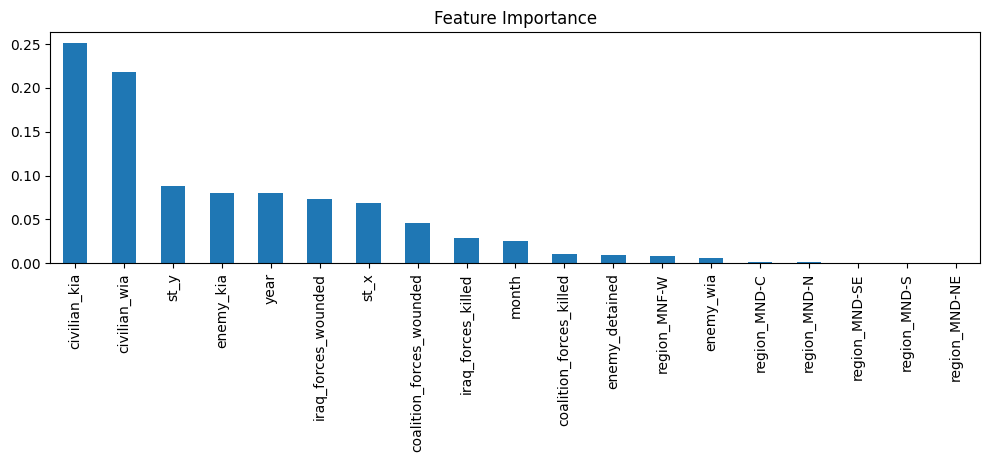

In [61]:
#Plotting the feature importance
varImp.plot.bar(figsize = (12,3),
               title = "Feature Importance",)

The most relevant features are certainly the statistics related to civilian victims, location, and time.

To comprehend the direction of the relationship it's necessary to use partial dependence plots or independent conditional expectation (source: https://scikit-learn.org/stable/modules/partial_dependence.html). These methods are used independently for each class.

Let's start from the most important features: the civilian statistics. The following chunks of code show the partial dependence plots for each category, that allow to study the dependence of the event from the civilian numbers.

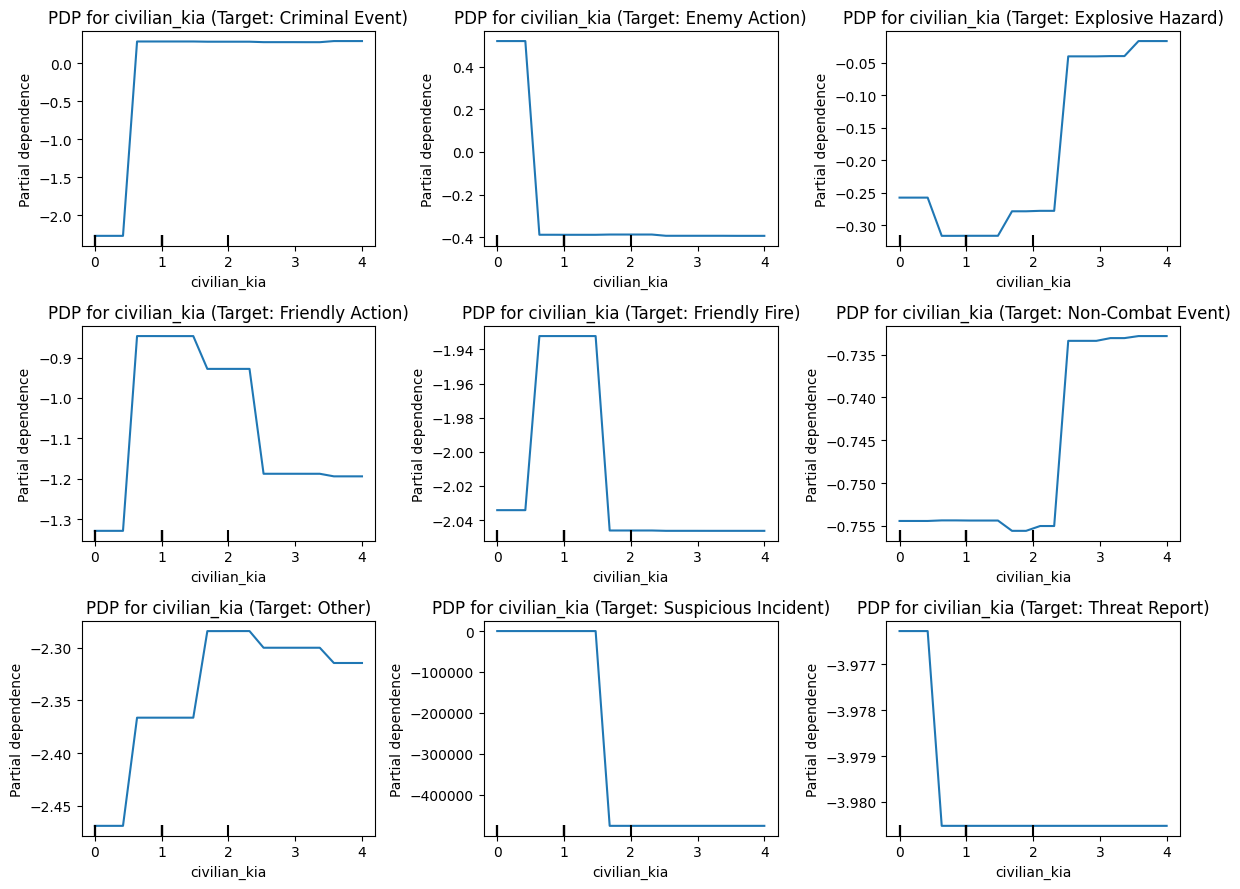

In [63]:
from sklearn.inspection import PartialDependenceDisplay

target_classes = GBmodel.classes_

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4 * 3, 3 * 3))
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
        ax = axes[i]
        display = PartialDependenceDisplay.from_estimator(
            estimator=GBmodel,
            X=train_set.drop("Type", axis=1),
            features=["civilian_kia"],
            target=target_class,
            grid_resolution=20,
            n_jobs=4,
            verbose=0,
            ax=ax
        )
        ax.set_title(f"PDP for civilian_kia (Target: {target_class})")

if len(target_classes) < len(axes):
    for j in range(len(target_classes), len(axes)):
        fig.delaxes(axes[j])
        
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

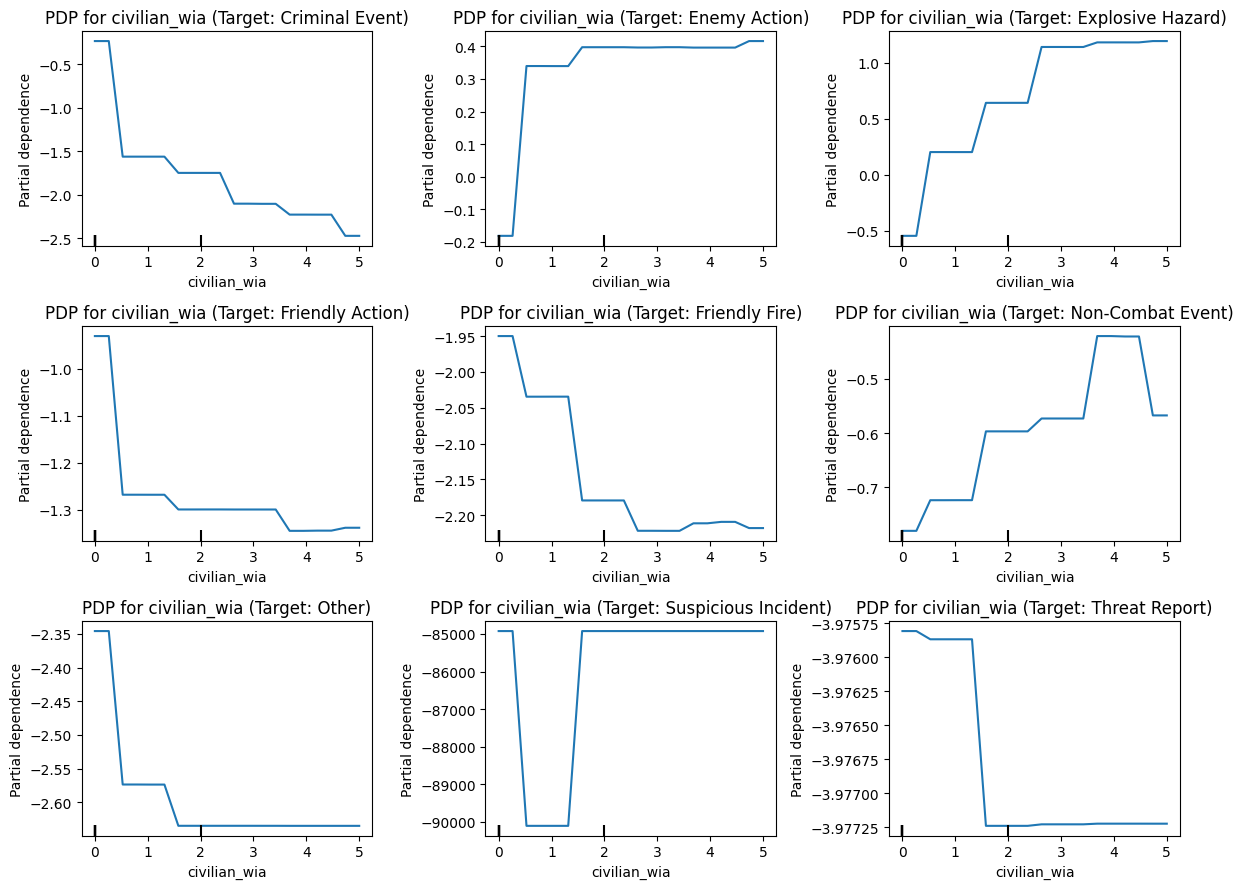

In [64]:
target_classes = GBmodel.classes_

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4 * 3, 3 * 3))
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
        ax = axes[i]
        display = PartialDependenceDisplay.from_estimator(
            estimator=GBmodel,
            X=train_set.drop("Type", axis=1),
            features=["civilian_wia"],
            target=target_class,
            grid_resolution=20,
            n_jobs=4,
            verbose=0,
            ax=ax
        )
        ax.set_title(f"PDP for civilian_wia (Target: {target_class})")

if len(target_classes) < len(axes):
    for j in range(len(target_classes), len(axes)):
        fig.delaxes(axes[j])
        
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Relation to civilian statistics
In terms of civilian deaths:
* Criminal Events, Explosive Hazards, Non-Combat Events and Other events are characterized by an higher number of civilians killed. Obviously, reading the range of the partial dependence (y axis) we can see that for some events, this relation is stronger, such as Criminal Events and Explosive Hazards.
* Enemy Actions, Friendly Actions, Suspicious Incidents and Threat Reporst (the last 2 are less trustworthy, as the cases are few) show higher correlation to lower levels of civilian deaths. this last result is strange, as in the exploratory analysis we saw how Threat Reporst showed higher mean number of civilian deaths. The model, in particular, doesn't allocate cases to this class, indicating that this result is not to be trusted.

In terms of civilian wounded, the results somewhat match, but there exist small differences:
* For Criminal Events, Enemy Actions and Other events, the correlation between events and number of civlians wounded is the opposite to the relations killed-Event probability. So these events can be characterized by a lot of wounded, but lower deaths, or more deaths, but lower wounded.

Next, let's explore the relation between geographical location and event type. In this case, the coordinates will be used. As the coordinates identify a 2D space, it's proper to explore the variables together, using the partial dependence plots of the interaction between the two.

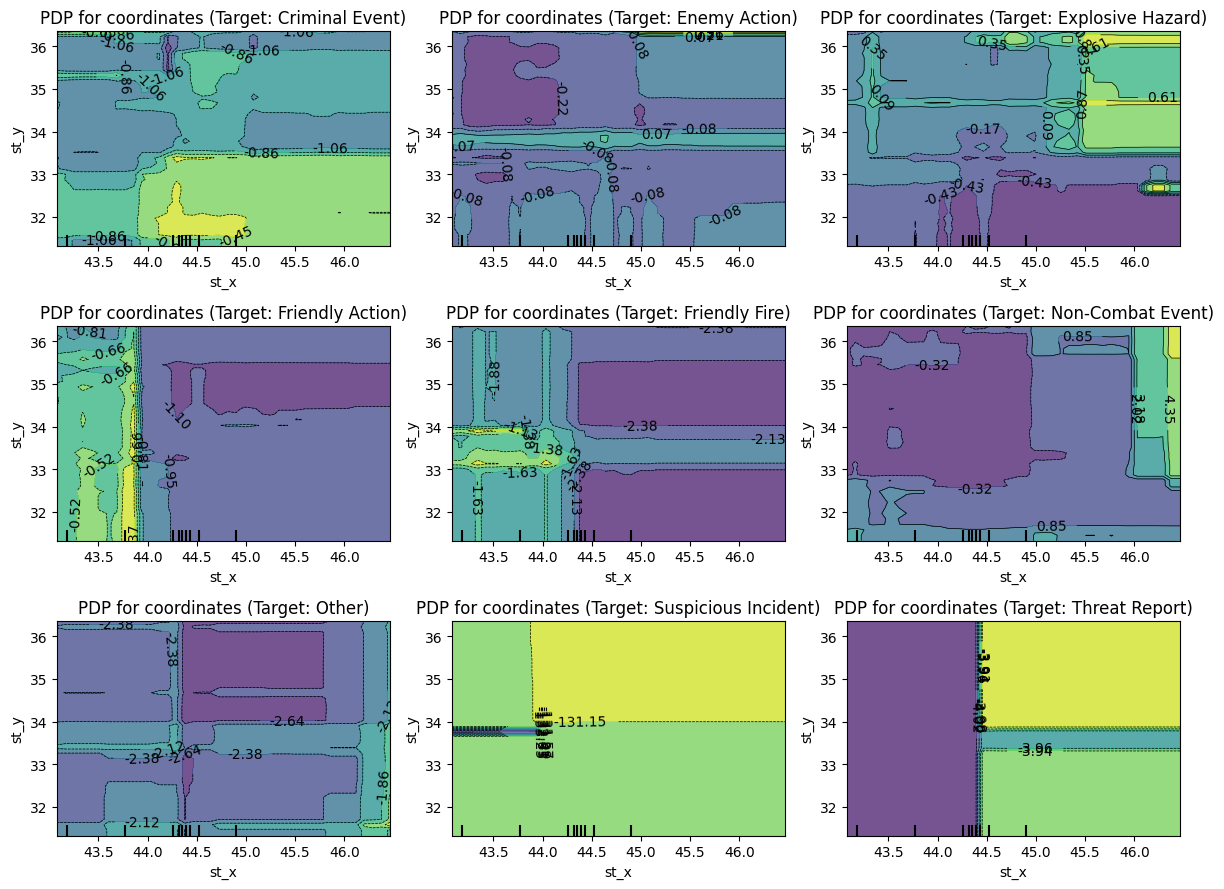

In [65]:
target_classes = GBmodel.classes_

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4 * 3, 3 * 3))
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
        ax = axes[i]
        display = PartialDependenceDisplay.from_estimator(
            estimator=GBmodel,
            X=train_set.drop("Type", axis=1),
            features=[("st_x","st_y")],
            target=target_class,
            grid_resolution=40,
            n_jobs=4,
            verbose=0,
            ax=ax
        )
        ax.set_title(f"PDP for coordinates (Target: {target_class})")

if len(target_classes) < len(axes):
    for j in range(len(target_classes), len(axes)):
        fig.delaxes(axes[j])
        
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Relation to geographical coordinates
Clearly, the suspicious incidents and the threat reports plot make less sense: the two classes had too few cases. Yellower regions are characterized by higher probabilities.

It's hard to give meaning to each plot individually, as there are many. Considering everything tough, it's clear how:
* The coordinates are important in determining the likelihood of event types, as these happen in different areas of Iraq. This could be due to the fact that the conflict is concentrated in some areas, rather than others.
* Criminal events are concentrated in the lower-center part of the space considered, while Explosive Hazard events in the upper-right zone, as the Non-Combat events. In the eastern part of Iraq there appears to happen more easily "Friendly Actions" and "Friendly Fire" accidents.

These plots can't be confronted, as the scales of probability and the colors differ from one plot to the other. But it helps to show where each event is more likely to happen.

The last feature that will be considered is the year, that represents the evolution of the conflict. In time, the position of the military personnel and the warfare itself could have changed, and "year" will help to undestand how.

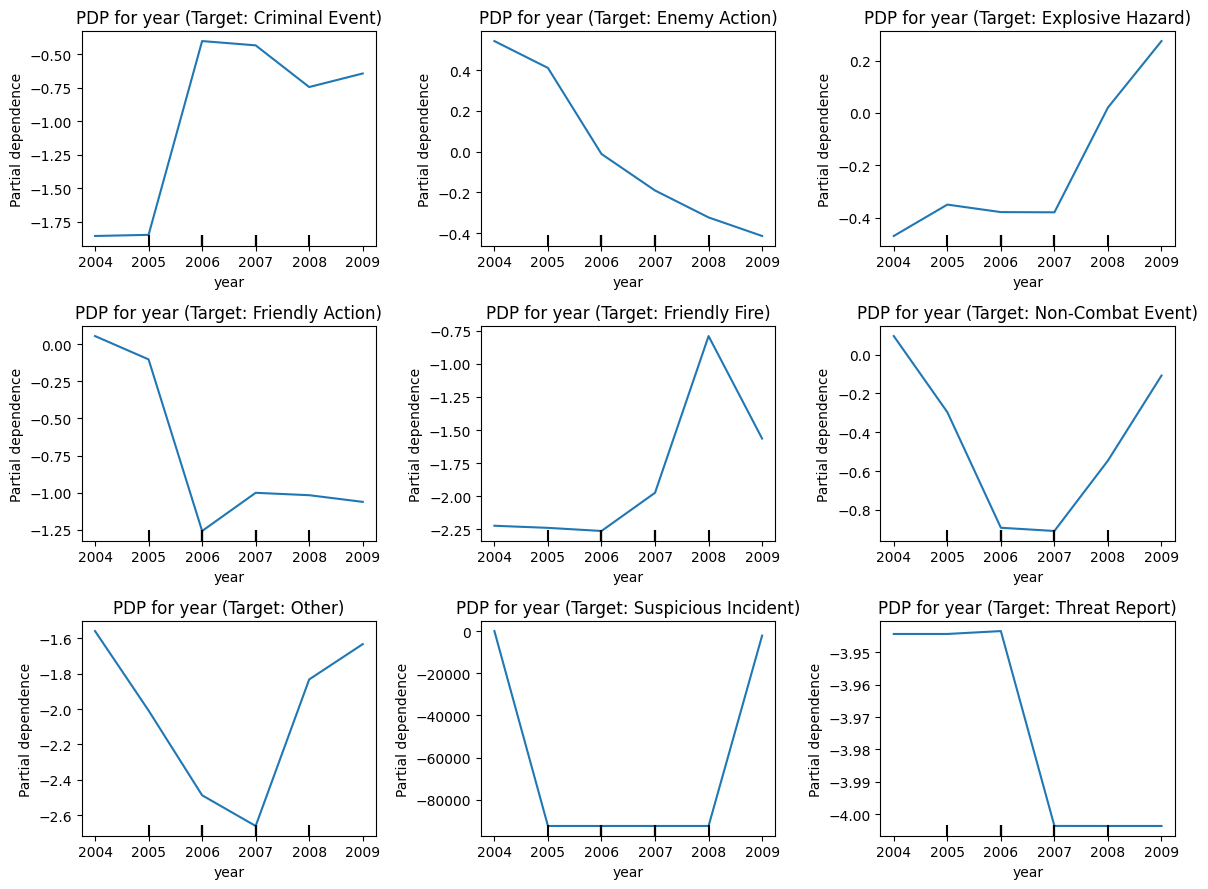

In [66]:
target_classes = GBmodel.classes_

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4 * 3, 3 * 3))
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
        ax = axes[i]
        display = PartialDependenceDisplay.from_estimator(
            estimator=GBmodel,
            X=train_set.drop("Type", axis=1),
            features=["year"],
            target=target_class,
            grid_resolution=20,
            n_jobs=4,
            verbose=0,
            ax=ax
        )
        ax.set_title(f"PDP for year (Target: {target_class})")

if len(target_classes) < len(axes):
    for j in range(len(target_classes), len(axes)):
        fig.delaxes(axes[j])
        
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Clearly, through the years of conflict, the type of warfare changed. With time, Criminal Events, Explosive Hards and Friendly Fire events increased, while Enemy Actions and Friendly Actions increased.

Some events show a less regular shape: Non-Combat Events, Other events and Suspicious Incidents. These Events were more likely at the start and at the end of the conflict. These classes where much less numerous, so this conclusion should be taken with caution.

# Possible improvements
The objective of this work was to gain some experience using Python, in particular pandas, sklearn and matplotlib. For this reason, the analysis itself is pretty simple.

Possible improvements to the work include different models (neural networks, for example), that could better model the dependency; or better algorithms for the same models used (such as extreme gradient boosting).

The most important problem with this data was the imbalance of the classes, and the fact that some categories had too low of a case count. The best way to improve the results would be to include more cases.